In [31]:
!pip install spotipy

In [32]:
import json
import pandas as pd
import numpy as np
import spotipy
import requests
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
import os
from collections import defaultdict

In [33]:
# get the dataframes
import os

def normalize(x):
  return (x / (x.max() - x.min()))

data_path = "./jte240_data"
prefix = "jte240_"
dataset_detailed_df = pd.read_csv(f'{data_path}/{prefix}history_with_features')
dataset_detailed_df = dataset_detailed_df.drop_duplicates(subset="id").reset_index()
dataset_detailed_df
labels = ['energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo'] 
dataset_features = dataset_detailed_df[labels]
dataset_features['loudness'] = dataset_features['loudness'] * -1
dataset_features_normalized = pd.DataFrame(np.apply_along_axis(normalize, 0, dataset_features.values))
dataset_features_normalized.columns = labels
dataset_features_normalized

/var/folders/fv/r1yqsvw1093g2dkcxww2w50r0000gn/T/ipykernel_36236/1541931416.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_features['loudness'] = dataset_features['loudness'] * -1


,energy,loudness,speechiness,acousticness,liveness,valence,tempo
0,0.900018,0.114760,0.051688,0.012651,0.105285,0.606742,0.553117
1,0.614012,0.143876,0.049156,0.059137,0.091792,0.363636,0.946648
2,0.593012,0.199123,0.039873,0.015161,0.057447,0.625128,0.562313
3,0.750015,0.116726,0.043460,0.002078,0.082592,0.946885,0.543963
4,0.836017,0.144184,0.041034,0.038855,0.120617,0.479060,0.493330
...,...,...,...,...,...,...,...
3798,0.967020,0.063990,0.079641,0.014759,0.111418,0.348315,0.603483
3799,0.932019,0.056882,0.214135,0.007139,0.180926,0.648621,0.696765
3800,0.933019,0.082350,0.208861,0.045884,0.384340,0.723187,0.784175
3801,0.923019,0.106894,0.145570,0.002831,0.161505,0.677222,0.834619


In [34]:
dataset_features_normalized

,energy,loudness,speechiness,acousticness,liveness,valence,tempo
0,0.900018,0.114760,0.051688,0.012651,0.105285,0.606742,0.553117
1,0.614012,0.143876,0.049156,0.059137,0.091792,0.363636,0.946648
2,0.593012,0.199123,0.039873,0.015161,0.057447,0.625128,0.562313
3,0.750015,0.116726,0.043460,0.002078,0.082592,0.946885,0.543963
4,0.836017,0.144184,0.041034,0.038855,0.120617,0.479060,0.493330
...,...,...,...,...,...,...,...
3798,0.967020,0.063990,0.079641,0.014759,0.111418,0.348315,0.603483
3799,0.932019,0.056882,0.214135,0.007139,0.180926,0.648621,0.696765
3800,0.933019,0.082350,0.208861,0.045884,0.384340,0.723187,0.784175
3801,0.923019,0.106894,0.145570,0.002831,0.161505,0.677222,0.834619


In [35]:
# estimate the bandwidth
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(dataset_features_normalized)
bandwidth

0.5732596190191881

In [36]:
bandwidth

0.5732596190191881

In [37]:
# numcluster = []
# for trybw in range(10, 70, 10):
#   print(trybw / 100)
#   meanshift = MeanShift(bandwidth=trybw/100)
#   meanshift.fit(dataset_features_normalized)
#   numcluster.append(meanshift)
# [len(x.cluster_centers_) for x in numcluster]

In [38]:
from sklearn.cluster import MeanShift
meanshift = MeanShift(bandwidth=bandwidth)
meanshift.fit(dataset_features_normalized)

MeanShift(bandwidth=0.5732596190191881)

In [39]:
meanshift.cluster_centers_

array([[0.69814877, 0.15347853, 0.09197285, 0.14018644, 0.17898627,
        0.53101906, 0.56627443],
       [0.37286427, 0.27448387, 0.06719618, 0.64560656, 0.14433606,
        0.3325831 , 0.51760029],
       [0.74665152, 0.21291056, 0.89259685, 0.7503203 , 0.74447325,
        0.55617978, 0.47916337],
       [0.97676983, 0.51925492, 0.09905063, 0.85743067, 0.9774609 ,
        0.00473187, 0.58379426],
       [0.01920039, 0.93560768, 0.65400844, 0.85642666, 0.27598896,
        0.20224719, 0.81133789]])

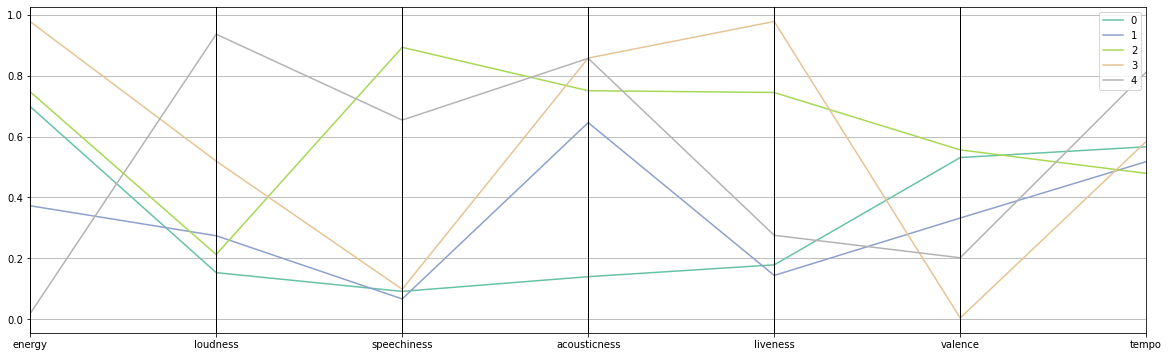

In [40]:
# vizualize the results
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

# Take the iris dataset
# import seaborn as sns
# data = sns.load_dataset('iris')
# data

cluster_df = pd.DataFrame(meanshift.cluster_centers_)
rightlabels = pd.DataFrame(np.arange(0, len(meanshift.cluster_centers_)))
cluster_df = pd.concat([cluster_df, rightlabels], axis = 1)
cluster_df.columns = labels + ['cluster']
cluster_df
# meanshift.cluster_centers_.shape
fig, axs = plt.subplots(figsize = (20,6)) 
parallel_coordinates(cluster_df, 'cluster', colormap=plt.get_cmap("Set2"))
plt.show()

In [41]:
points = meanshift.labels_
points.reshape(1, len(points))
points = pd.DataFrame(points)
points.columns = ["cluster"]
points.groupby("cluster")['cluster'].count()

cluster
0    2446
1    1274
2      36
3      17
4      30
Name: cluster, dtype: int64

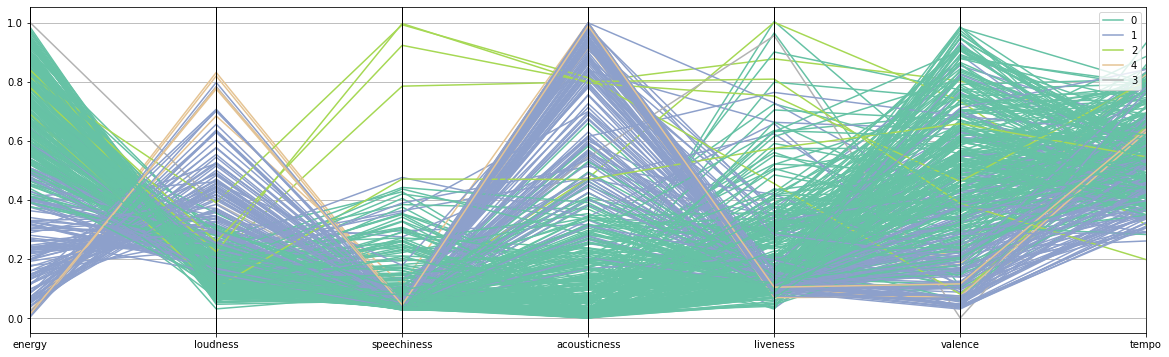

In [42]:
labeled_songs = pd.concat([dataset_features_normalized, points], axis=1)
fig, axs = plt.subplots(figsize = (20,6))
parallel_coordinates(labeled_songs[::10], 'cluster', colormap=plt.get_cmap("Set2"))
plt.show()

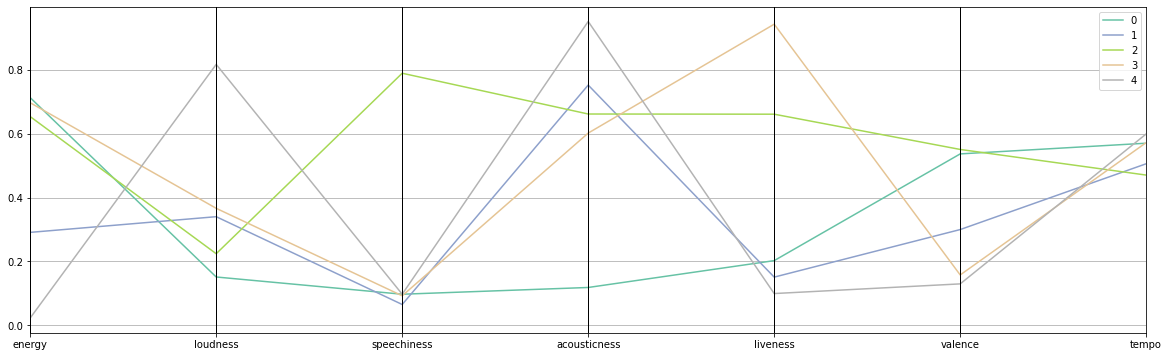

In [43]:
fig, axs = plt.subplots(figsize = (20,6))
averaged = labeled_songs.groupby("cluster").mean()
averaged = pd.concat([averaged, rightlabels], axis = 1)
averaged.columns.values[-1] = "cluster"
averaged
parallel_coordinates(averaged, 'cluster', colormap=plt.get_cmap("Set2"))
plt.show()

In [44]:
from sklearn.cluster import AgglomerativeClustering
num_agglo_clusters = 4 
agglo = AgglomerativeClustering(n_clusters=num_agglo_clusters)
agglo.fit(dataset_features_normalized)


AgglomerativeClustering(n_clusters=4)

In [45]:
agglo.n_clusters
len(agglo.labels_)
agglolabels = pd.DataFrame(agglo.labels_)
agglo_songs = pd.concat([dataset_features_normalized, agglolabels], axis=1)
agglo_songs.columns.values[-1] = "cluster"
agglo_songs.groupby("cluster")["cluster"].count()

cluster
0    1564
1     704
2     981
3     554
Name: cluster, dtype: int64

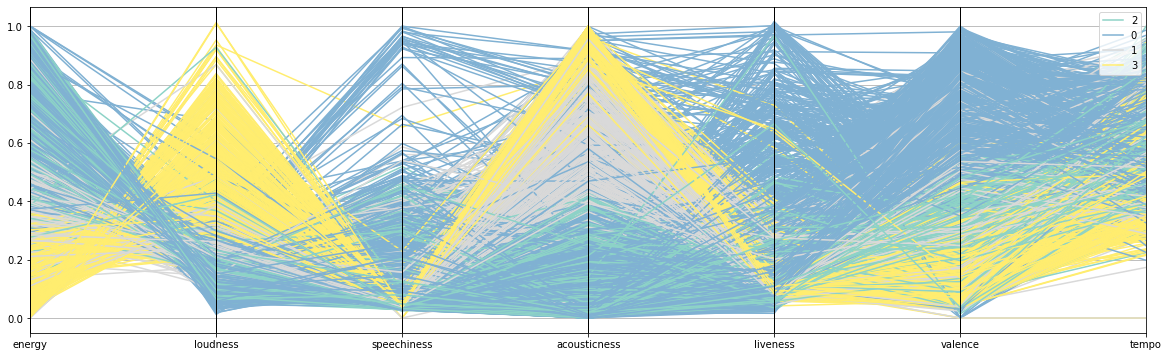

In [46]:
fig, axs = plt.subplots(figsize = (20,6)) 
parallel_coordinates(agglo_songs, 'cluster', colormap=plt.get_cmap("Set3"))
plt.show()

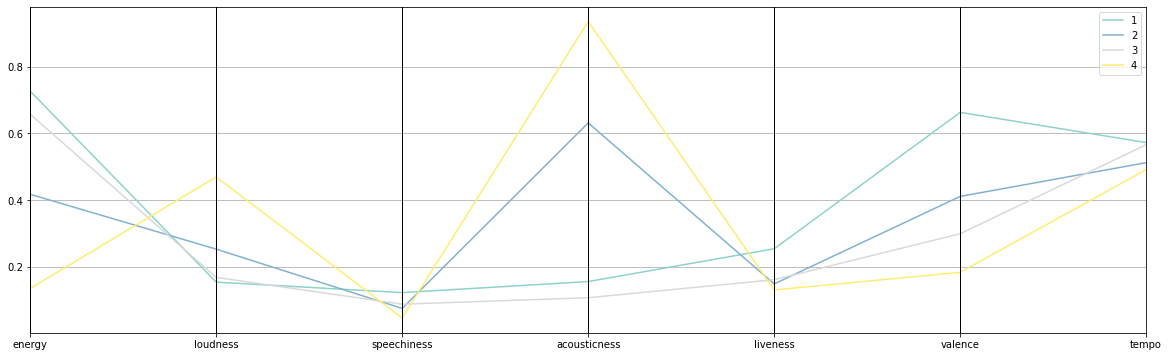

In [47]:
averaged_agglo = agglo_songs.groupby("cluster").mean()
averaged_agglo = pd.concat([averaged_agglo, pd.DataFrame(np.arange(1, num_agglo_clusters + 1))], axis=1)
averaged_agglo.columns.values[-1] = "cluster"
averaged_agglo

fig, axs = plt.subplots(figsize = (20,6)) 
parallel_coordinates(averaged_agglo, 'cluster', colormap=plt.get_cmap("Set3"))
plt.show()

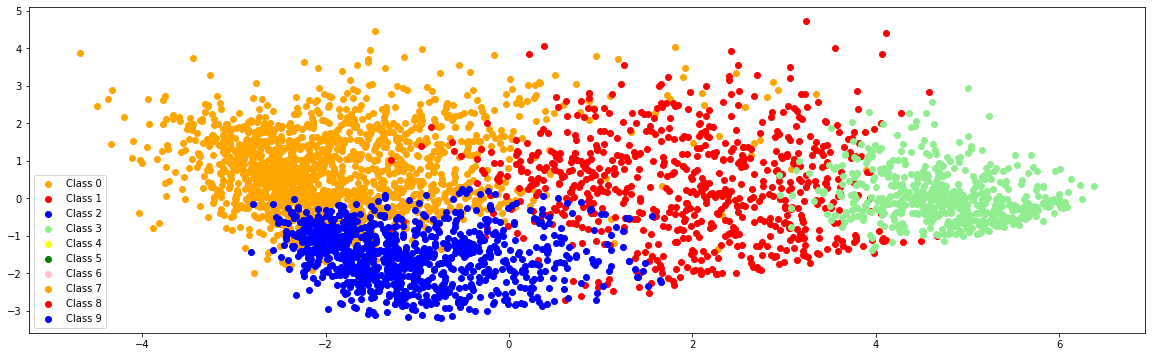

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
lda = LinearDiscriminantAnalysis() 
agglopredictions = agglolabels.values.reshape(len(agglolabels.values))
lda_transformed = pd.DataFrame(lda.fit_transform(dataset_features_normalized.values, agglopredictions))
fig, axs = plt.subplots(figsize = (20,6)) 

# nice n_clusters values: ~3, ~4, 

plt.scatter(lda_transformed[agglopredictions==0][0], lda_transformed[agglopredictions==0][1], label='Class 0', c='orange')
plt.scatter(lda_transformed[agglopredictions==1][0], lda_transformed[agglopredictions==1][1], label='Class 1', c='red')
plt.scatter(lda_transformed[agglopredictions==2][0], lda_transformed[agglopredictions==2][1], label='Class 2', c='blue')
plt.scatter(lda_transformed[agglopredictions==3][0], lda_transformed[agglopredictions==3][1], label='Class 3', c='lightgreen')
plt.scatter(lda_transformed[agglopredictions==4][0], lda_transformed[agglopredictions==4][1], label='Class 4', c='yellow')
plt.scatter(lda_transformed[agglopredictions==5][0], lda_transformed[agglopredictions==5][1], label='Class 5', c='green')
plt.scatter(lda_transformed[agglopredictions==6][0], lda_transformed[agglopredictions==6][1], label='Class 6', c='pink')
plt.scatter(lda_transformed[agglopredictions==7][0], lda_transformed[agglopredictions==7][1], label='Class 7', c='orange')
plt.scatter(lda_transformed[agglopredictions==8][0], lda_transformed[agglopredictions==8][1], label='Class 8', c='red')
plt.scatter(lda_transformed[agglopredictions==9][0], lda_transformed[agglopredictions==9][1], label='Class 9', c='blue')
    
# Display legend and show plot
plt.legend(loc=3)
plt.show()